[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)
[![Open In Kaggle](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-kaggle.svg)](https://www.kaggle.com/code/crunchdao/structural-break-baseline)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [63]:
# Install the Crunch CLI
%pip install crunch-cli --upgrade --quiet --progress-bar off

# Setup your local environment
!crunch setup-notebook structural-break jUwZkZ7m3MZRmnP247obofdF

Note: you may need to restart the kernel to use updated packages.
crunch-cli, version 7.4.0

---
Your token seems to have expired or is invalid.

Please follow this link to copy and paste your new setup command:
https://hub.crunchdao.com/competitions/structural-break/submit

If you think that is an error, please contact an administrator.


# Your model

## Setup

In [64]:
import os
import typing

# Import your dependencies
import joblib
import pandas as pd
import scipy
import sklearn.metrics

In [65]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 7.4.0
available ram: 22.88 gb
available cpu: 16 core
----


## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [66]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: (arbitrary) The time step within each time series, which is regularly sampled

**Columns:**
- `value`: The values of the time series at each given time step
- `period`: whether you are in the first part of the time series (`0`), before the presumed break point, or in the second part (`1`), after the break point

In [67]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a time series id has a structural break, or not, from the presumed break point on.

**Index:**
- `id`: the ID of the time series

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [68]:
y_train

id
0        False
1        False
2         True
3        False
4        False
         ...  
9996     False
9997     False
9998     False
9999     False
10000     True
Name: structural_breakpoint, Length: 10001, dtype: bool

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [69]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [70]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

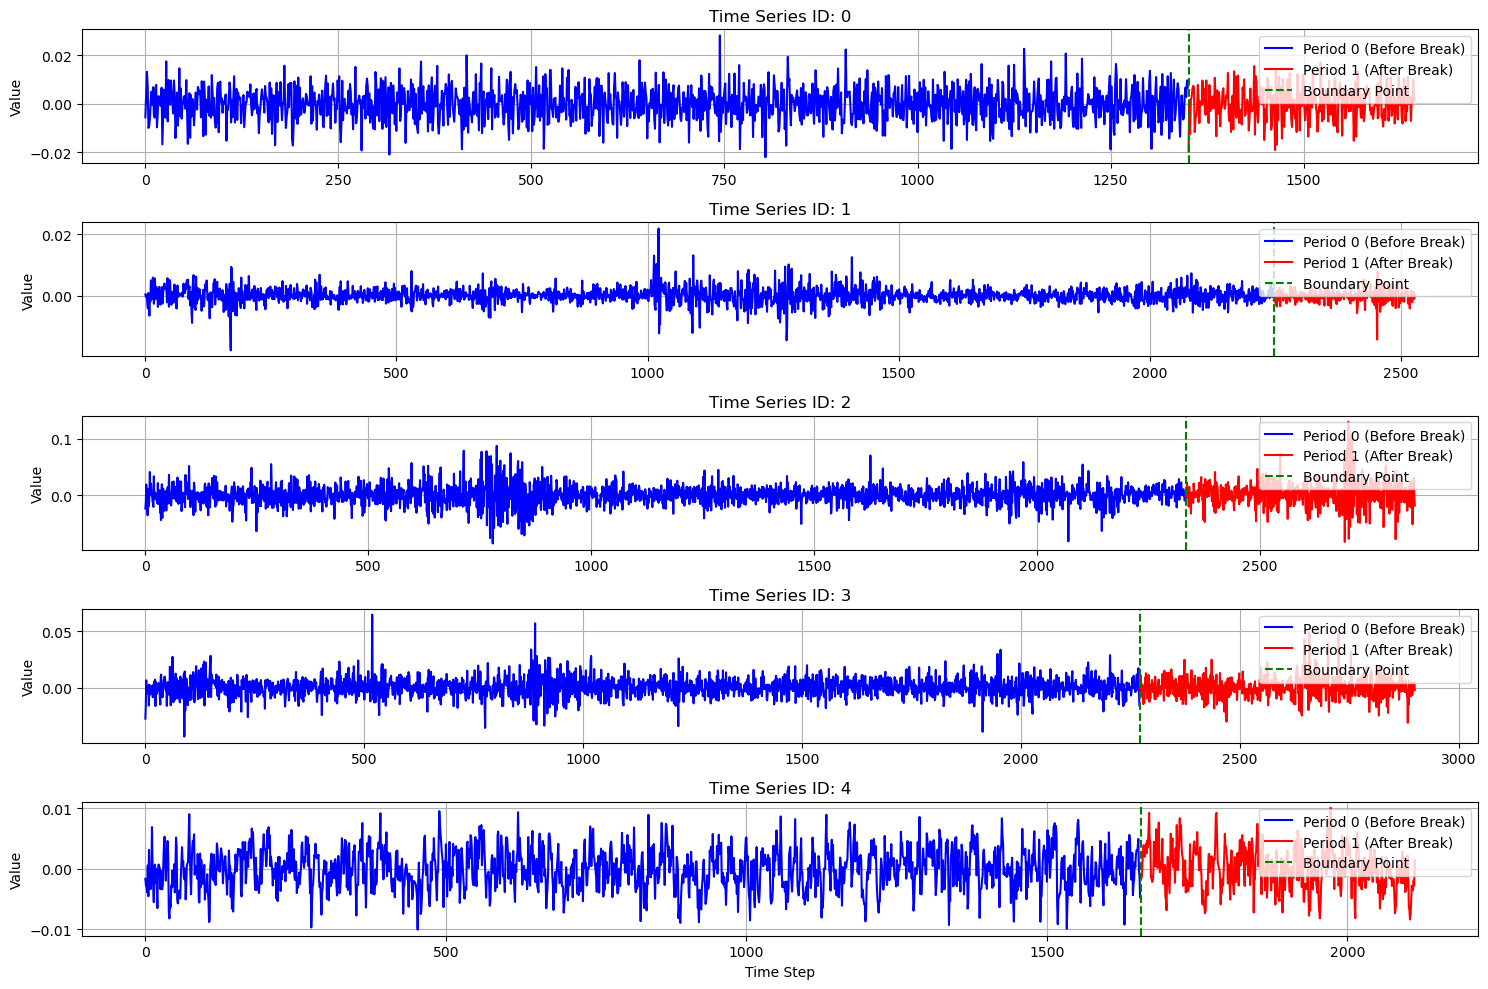

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

unique_ids = X_train.index.get_level_values('id').unique()
num_series = 5

plt.figure(figsize=(15, 10))

for i, series_id in enumerate(unique_ids[:num_series]):
    # Select the data for a specific time series ID
    single_series_data = X_train.loc[series_id]

    # Get the values before the break point (period == 0)
    period_0_data = single_series_data[single_series_data['period'] == 0]['value']
    # Get the values after the break point (period == 1)
    period_1_data = single_series_data[single_series_data['period'] == 1]['value']

    plt.subplot(num_series, 1, i + 1) # Create a subplot for each series
    plt.plot(period_0_data.index, period_0_data.values, label='Period 0 (Before Break)', color='blue')
    plt.plot(period_1_data.index, period_1_data.values, label='Period 1 (After Break)', color='red')

    # Add a vertical line at the boundary point if desired
    # The boundary is where period changes from 0 to 1.
    # The last index of period 0 is the point right before the boundary.
    # The first index of period 1 is the point at or after the boundary.
    # A simple way to mark the boundary is to use the first 'time' index where period becomes 1.
    boundary_time = single_series_data[single_series_data['period'] == 1].index.min()
    if pd.notna(boundary_time):
        plt.axvline(x=boundary_time, color='green', linestyle='--', label='Boundary Point')


    plt.title(f'Time Series ID: {series_id}')
    plt.ylabel('Value')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.xlabel('Time Step')
plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()


In [ ]:
def extract_features(series_data: pd.DataFrame) -> pd.Series:
    """
    Extracts statistical features from a single time series, comparing properties
    before (period=0) and after (period=1) the boundary.
    Returns np.nan for features that cannot be computed due to insufficient data.
    """
    period_0 = series_data[series_data['period'] == 0]['value']
    period_1 = series_data[series_data['period'] == 1]['value']

    features = {}

    features['period0_len'] = len(period_0)
    features['period1_len'] = len(period_1)
    features['period0_empty'] = 1 if period_0.empty else 0
    features['period1_empty'] = 1 if period_1.empty else 0
    features['period0_single_point'] = 1 if len(period_0) == 1 else 0
    features['period1_single_point'] = 1 if len(period_1) == 1 else 0


    for p, prefix in [(period_0, '0'), (period_1, '1')]:
        features[f'mean_{prefix}'] = p.mean()
        features[f'std_{prefix}'] = p.std()
        features[f'var_{prefix}'] = p.var()
        features[f'skew_{prefix}'] = p.skew()
        features[f'kurt_{prefix}'] = p.kurt()
        features[f'median_{prefix}'] = p.median()
        features[f'q25_{prefix}'] = p.quantile(0.25)
        features[f'q75_{prefix}'] = p.quantile(0.75)
        features[f'min_{prefix}'] = p.min()
        features[f'max_{prefix}'] = p.max()
        features[f'num_unique_{prefix}'] = p.nunique()

        features[f'iqr_{prefix}'] = features[f'q75_{prefix}'] - features[f'q25_{prefix}']
        features[f'range_{prefix}'] = features[f'max_{prefix}'] - features[f'min_{prefix}']
        features[f'cv_{prefix}'] = features[f'std_{prefix}'] / features[f'mean_{prefix}'] if features[f'mean_{prefix}'] != 0 else np.nan # Coefficient of Variation

    if not period_0.empty and not period_1.empty:
        features['mean_diff'] = features['mean_1'] - features['mean_0']
        features['median_diff'] = features['median_1'] - features['median_0']
        features['skew_diff'] = features['skew_1'] - features['skew_0']
        features['kurt_diff'] = features['kurt_1'] - features['kurt_0']
        features['range_diff'] = features['range_1'] - features['range_0']
        features['iqr_diff'] = features['iqr_1'] - features['iqr_0']

        features['std_ratio'] = features['std_1'] / features['std_0'] if features['std_0'] != 0 else np.nan
        features['log_std_ratio'] = np.log(features['std_ratio']) if features['std_ratio'] > 0 and np.isfinite(features['std_ratio']) else np.nan

        features['var_ratio'] = features['var_1'] / features['var_0'] if features['var_0'] != 0 else np.nan
        features['log_var_ratio'] = np.log(features['var_ratio']) if features['var_ratio'] > 0 and np.isfinite(features['var_ratio']) else np.nan

        features['iqr_ratio'] = features['iqr_1'] / features['iqr_0'] if features['iqr_0'] != 0 else np.nan
        features['log_iqr_ratio'] = np.log(features['iqr_ratio']) if features['iqr_ratio'] > 0 and np.isfinite(features['iqr_ratio']) else np.nan

        features['len_ratio'] = features['period1_len'] / features['period0_len'] if features['period0_len'] != 0 else np.nan

        features['cv_ratio'] = features['cv_1'] / features['cv_0'] if features['cv_0'] != 0 else np.nan
        features['log_cv_ratio'] = np.log(features['cv_ratio']) if features['cv_ratio'] > 0 and np.isfinite(features['cv_ratio']) else np.nan

    # T-test (Welch's): for mean comparison, unequal variances
    try:
        if len(period_0) > 1 and len(period_1) > 1: # Need at least 2 points for meaningful t-test
            _, pvalue_ttest = scipy.stats.ttest_ind(period_0.dropna(), period_1.dropna(), equal_var=False, nan_policy='omit')
            features['ttest_pvalue'] = pvalue_ttest
        else:
            features['ttest_pvalue'] = np.nan
    except ValueError:
        features['ttest_pvalue'] = np.nan

    # Levene's test: for variance comparison (robust to non-normality)
    try:
        if len(period_0) > 1 and len(period_1) > 1:
            _, pvalue_levene = scipy.stats.levene(period_0.dropna(), period_1.dropna(), center='median') # 'median' is more robust
            features['levene_pvalue'] = pvalue_levene
        else:
            features['levene_pvalue'] = np.nan
    except ValueError:
        features['levene_pvalue'] = np.nan

    # Kolmogorov-Smirnov test: for general distribution comparison
    try:
        if len(period_0) >= 1 and len(period_1) >= 1:
            _, pvalue_ks = scipy.stats.ks_2samp(period_0.dropna(), period_1.dropna())
            features['ks_pvalue'] = pvalue_ks
        else:
            features['ks_pvalue'] = np.nan
    except ValueError:
        features['ks_pvalue'] = np.nan

    # Mann-Whitney U test: non-parametric test for location (median) comparison
    try:
        if len(period_0) >= 1 and len(period_1) >= 1:
            _, pvalue_mw = scipy.stats.mannwhitneyu(period_0.dropna(), period_1.dropna(), alternative='two-sided', nan_policy='omit')
            features['mannwhitneyu_pvalue'] = pvalue_mw
        else:
            features['mannwhitneyu_pvalue'] = np.nan
    except ValueError:
        features['mannwhitneyu_pvalue'] = np.nan

    # Autocorrelation at Lag 1
    if features['period0_len'] > 1:
        features['autocorr_lag1_0'] = period_0.autocorr(lag=1)
    else:
        features['autocorr_lag1_0'] = np.nan
    if features['period1_len'] > 1:
        features['autocorr_lag1_1'] = period_1.autocorr(lag=1)
    else:
        features['autocorr_lag1_1'] = np.nan
    features['autocorr_lag1_diff'] = features['autocorr_lag1_1'] - features['autocorr_lag1_0']

    # Linear Regression Slope (requires at least 2 points)
    if features['period0_len'] > 1:
        slope_0, _, _, _, _ = linregress(period_0.index.get_level_values('time').values, period_0.values)
        features['slope_0'] = slope_0
    else:
        features['slope_0'] = np.nan
    if features['period1_len'] > 1:
        slope_1, _, _, _, _ = linregress(period_1.index.get_level_values('time').values, period_1.values)
        features['slope_1'] = slope_1
    else:
        features['slope_1'] = np.nan
    features['slope_diff'] = features['slope_1'] - features['slope_0']

    # Rolling Window Statistics (mean of rolling stats) 
    rolling_windows = [5, 10, 20] # Small windows for local changes

    for window_size in rolling_windows:
        if features['period0_len'] >= window_size:
            features[f'rolling_mean_mean_{window_size}_0'] = period_0.rolling(window=window_size).mean().mean()
            features[f'rolling_std_mean_{window_size}_0'] = period_0.rolling(window=window_size).std().mean()
            features[f'rolling_max_mean_{window_size}_0'] = period_0.rolling(window=window_size).max().mean()
            features[f'rolling_min_mean_{window_size}_0'] = period_0.rolling(window=window_size).min().mean()
        else:
            features[f'rolling_mean_mean_{window_size}_0'] = np.nan
            features[f'rolling_std_mean_{window_size}_0'] = np.nan
            features[f'rolling_max_mean_{window_size}_0'] = np.nan
            features[f'rolling_min_mean_{window_size}_0'] = np.nan

        if features['period1_len'] >= window_size:
            features[f'rolling_mean_mean_{window_size}_1'] = period_1.rolling(window=window_size).mean().mean()
            features[f'rolling_std_mean_{window_size}_1'] = period_1.rolling(window=window_size).std().mean()
            features[f'rolling_max_mean_{window_size}_1'] = period_1.rolling(window=window_size).max().mean()
            features[f'rolling_min_mean_{window_size}_1'] = period_1.rolling(window=window_size).min().mean()
        else:
            features[f'rolling_mean_mean_{window_size}_1'] = np.nan
            features[f'rolling_std_mean_{window_size}_1'] = np.nan
            features[f'rolling_max_mean_{window_size}_1'] = np.nan
            features[f'rolling_min_mean_{window_size}_1'] = np.nan

        # Differences of rolling stats
        features[f'rolling_mean_mean_diff_{window_size}'] = features[f'rolling_mean_mean_{window_size}_1'] - features[f'rolling_mean_mean_{window_size}_0']
        features[f'rolling_std_mean_diff_{window_size}'] = features[f'rolling_std_mean_{window_size}_1'] - features[f'rolling_std_mean_{window_size}_0']
        features[f'rolling_max_mean_diff_{window_size}'] = features[f'rolling_max_mean_{window_size}_1'] - features[f'rolling_max_mean_{window_size}_0']
        features[f'rolling_min_mean_diff_{window_size}'] = features[f'rolling_min_mean_{window_size}_1'] - features[f'rolling_min_mean_{window_size}_0']


    return pd.Series(features)


### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [77]:
import os
import typing
import joblib
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import warnings
from scipy.stats import linregress
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # feature engineering
    X_train_features = X_train.groupby('id', group_keys=False).apply(extract_features)
    #X_train_features.fillna(X_train_features.median(), inplace=True)
    X_train_features.dropna(axis=1, how='all', inplace=True)

    imputer_values = X_train_features.median().to_dict()
    X_train_features.fillna(imputer_values, inplace=True)
    y_train_aligned = y_train.loc[X_train_features.index]

    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    base_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    param_dist = {
        'n_estimators': [100, 200, 300], # Number of trees in the forest
        'max_depth': [10, 20, 30, None], # Max depth of tree. None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples.
        'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2', 0.8, 1.0], # Number of features to consider when looking for the best split
        'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
    }

    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        verbose=1,
        random_state=24,
        n_jobs=8,
        scoring='roc_auc'
    )
    random_search.fit(X_train_features, y_train_aligned)
    model = random_search.best_estimator_

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))
    joblib.dump(X_train_features.columns.tolist(), os.path.join(model_directory_path, 'feature_names.joblib'))
    joblib.dump(X_train_features.median().to_dict(), os.path.join(model_directory_path, 'imputer_values.joblib'))
    print("Random Forest model trained and saved.")

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [82]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))
    feature_names = joblib.load(os.path.join(model_directory_path, 'feature_names.joblib'))
    imputer_values = joblib.load(os.path.join(model_directory_path, 'imputer_values.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        test_features_series = extract_features(dataset)
        test_features = test_features_series.to_frame().T 
        for col in feature_names:
            if col not in test_features.columns:
                test_features[col] = np.nan
        
        """ def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue
        """
        test_features = test_features[feature_names]
        test_features.fillna(imputer_values, inplace=True)
        prediction = model.predict_proba(test_features)[:, 1][0]
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

ignoring cell #19: expected an indented block after function definition on line 1 (<unknown>, line 2)


18:42:28 no forbidden library found
18:42:28 
18:42:28 started
18:42:28 running local test
18:42:28 internet access isn't restricted, no check will be done
18:42:28 
18:42:28 starting unstructured loop...
18:42:28 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
Fitting 5 folds for each of 30 candidates, totalling 150 fits


19:22:05 executing - command=infer


Random Forest model trained and saved.


19:22:10 checking determinism by executing the inference again with 30% of the data (tolerance: 1e-08)
19:22:10 executing - command=infer
19:22:11 determinism check: passed
19:22:11 save prediction - path=data/prediction.parquet
19:22:11 ended
19:22:11 duration - time=00:39:43
19:22:11 memory - before="4.35 GB" after="2.67 GB" consumed="-1681981440 bytes"


Exception ignored in: <function ResourceTracker.__del__ at 0x7f2a0e7c3f60>
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f9cb21b3f60>
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f41c21c3f60>
Traceback (most recent call l

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [84]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

,prediction
id,
10001,0.237057
10002,0.214953
10003,0.237043
10004,0.206916
10005,0.289562
...,...
10097,0.265534
10098,0.209165
10099,0.376079


### Local scoring

You can call the function that the system uses to estimate your score locally.

In [85]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

np.float64(0.6671361502347418)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)